Lets go into the business case study observation. We want to overcome to the the problem that the hosts face in determining the optimal night rental price. The price should be nearby to the marketplace or renters. If the charge > market place, then renter will go to other alternaitve and if low then we will miss out with the potential revenue. So, the strategy would be:
1) We will find few listings that are similar to our
2) We will average those listings
3) Set this listing price to the calculated average price
    
    


We will build machine learning model to automate this process with the technique called k-nearest neighbors

In [2]:
import pandas as pd 
import numpy as np
np.random.seed(1)

In [3]:
dc_listings=pd.read_csv("dc_airbnb.csv")
dc_listings=dc_listings.loc[np.random.permutation(len(dc_listings))]
stripped_commas = dc_listings['price'].str.replace(',', '')
stripped_dollars = stripped_commas.str.replace('$', '')
dc_listings['price'] = stripped_dollars.astype('float')
print(dc_listings.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3723 entries, 574 to 1061
Data columns (total 19 columns):
host_response_rate      3289 non-null object
host_acceptance_rate    3109 non-null object
host_listings_count     3723 non-null int64
accommodates            3723 non-null int64
room_type               3723 non-null object
bedrooms                3702 non-null float64
bathrooms               3696 non-null float64
beds                    3712 non-null float64
price                   3723 non-null float64
cleaning_fee            2335 non-null object
security_deposit        1426 non-null object
minimum_nights          3723 non-null int64
maximum_nights          3723 non-null int64
number_of_reviews       3723 non-null int64
latitude                3723 non-null float64
longitude               3723 non-null float64
city                    3723 non-null object
zipcode                 3714 non-null object
state                   3723 non-null object
dtypes: float64(6), int64(5), objec

The following columns contain non-numerical values:
room_type: e.g. Private room
city: e.g. Washington
state: e.g. DC

while these columns contain numerical but non-ordinal values:
latitude: e.g. 38.913458
longitude: e.g. -77.031
zipcode: e.g. 20009

While we could convert the host_response_rate and host_acceptance_rate columns to be numerical (right now they're object data types and contain the % sign), these columns describe the host and not the living space itself. Since a host could have many living spaces and we don't have enough information to uniquely group living spaces to the hosts themselves, let's avoid using any columns that don't directly describe the living space or the listing itself:

host_response_rate
host_acceptance_rate
host_listings_count

Removing:
-3 containing non-numerical values
-3 containing numerical but non-ordinal values
-3 describing the host instead of the living space itself

In [4]:
drop_columns=['room_type', 'city', 'state', 'latitude', 'longitude', 'zipcode', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count']
dc_listings=dc_listings.drop(drop_columns,axis=1)
print(dc_listings.isnull().sum())

accommodates            0
bedrooms               21
bathrooms              27
beds                   11
price                   0
cleaning_fee         1388
security_deposit     2297
minimum_nights          0
maximum_nights          0
number_of_reviews       0
dtype: int64


Of the remaining columns, 3 columns have a few missing values (less than 1% of the total number of rows):
-bedrooms
-bathrooms
-beds
Since the number of rows containing missing values for one of these 3 columns is low, we can select and remove those rows without losing much information. There are also 2 columns that have a large number of missing values:

cleaning_fee - 37.3% of the rows
security_deposit - 61.7% of the rows
and we can't handle these easily. We can't just remove the rows containing missing values for these 2 columns because we'd miss out on the majority of the observations in the dataset. Instead, let's remove these 2 columns entirely from consideration

1)Drop the cleaning_fee and security_deposit columns from dc_listings.
2)Then, remove all rows that contain a missing value for the bedrooms, bathrooms, or beds column from dc_listings.
3)You can accomplish this by using the Dataframe method dropna() and setting the axis parameter to 0.
Since only the bedrooms, bathrooms, and beds columns contain any missing values, rows containing missing values in these columns will be removed.
4)Display the null value counts for the updated dc_listings Dataframe to confirm that there are no missing values left.

In [5]:
drop_columns1=['cleaning_fee','security_deposit']
dc_listings=dc_listings.drop(drop_columns1,axis=1)
dc_listings=dc_listings.dropna(axis=0)
print(dc_listings.isnull().sum())

accommodates         0
bedrooms             0
bathrooms            0
beds                 0
price                0
minimum_nights       0
maximum_nights       0
number_of_reviews    0
dtype: int64


In [6]:
dc_listings.info()
print(dc_listings)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3671 entries, 574 to 1061
Data columns (total 8 columns):
accommodates         3671 non-null int64
bedrooms             3671 non-null float64
bathrooms            3671 non-null float64
beds                 3671 non-null float64
price                3671 non-null float64
minimum_nights       3671 non-null int64
maximum_nights       3671 non-null int64
number_of_reviews    3671 non-null int64
dtypes: float64(4), int64(4)
memory usage: 258.1 KB
      accommodates  bedrooms  bathrooms  beds  price  minimum_nights  \
574              2       1.0        1.0   1.0  125.0               1   
1593             2       1.0        1.5   1.0   85.0               1   
3091             1       1.0        0.5   1.0   50.0               1   
420              2       1.0        1.0   1.0  209.0               4   
808             12       5.0        2.0   5.0  215.0               2   
3492             8       4.0        2.5   5.0  350.0               4   


Now what we noticed that while the accommodates, bedrooms, bathrooms, beds, and minimum_nights columns hover between 0 and 12 (at least in the first few rows), the values in the maximum_nights and number_of_reviews columns span much larger ranges. For example, the maximum_nights column has values as low as 4 and high as 1825, in the first few rows itself. If we use these 2 columns as part of a k-nearest neighbors model, these attributes could end up having an outsized effect on the distance calculations because of the largeness of the values.

For example, 2 living spaces could be identical across every attribute but be vastly different just on the maximum_nights column. If one listing had a maximum_nights value of 1825 and the other a maximum_nights value of 4, because of the way Euclidean distance is calculated, these listings would be considered very far apart because of the outsized effect the largeness of the values had on the overall Euclidean distance. To prevent any single column from having too much of an impact on the distance, we can normalize all of the columns to have a mean of 0 and a standard deviation of 1.

Normalizing the values in each column to the standard normal distribution (mean of 0, standard deviation of 1) preserves the distribution of the values in each column while aligning the scales. To normalize the values in a column to the standard normal distribution, you need to:

from each value, subtract the mean of the column
divide each value by the standard deviation of the column
Here's the mathematical formula describing the transformation that needs to be applied for all values in a column:

x=(x-mu)/sigma

where  is a value in a specific column,  is the mean of all the values in the column, and  is the standard deviation of all the values in the column. Here's what the corresponding code, using pandas, looks like:

So, lets normalize the columns in dc_listings

In [7]:
normalized_listings = (dc_listings - dc_listings.mean())/(dc_listings.std())
normalized_listings['price'] = dc_listings['price']
print(normalized_listings.head(3))


      accommodates  bedrooms  bathrooms      beds  price  minimum_nights  \
574      -0.596544 -0.249467  -0.439151 -0.546858  125.0       -0.341375   
1593     -0.596544 -0.249467   0.412923 -0.546858   85.0       -0.341375   
3091     -1.095499 -0.249467  -1.291226 -0.546858   50.0       -0.341375   

      maximum_nights  number_of_reviews  
574        -0.016604           4.579650  
1593       -0.016603           1.159275  
3091       -0.016573          -0.482505  


In [8]:
from scipy.spatial import distance
first_listing = normalized_listings.iloc[0][['accommodates', 'bathrooms']]
fifth_listing = normalized_listings.iloc[4][['accommodates', 'bathrooms']]
first_fifth_distance = distance.euclidean(first_listing, fifth_listing)
print(first_fifth_distance)


5.272543124668404


Use the distance.euclidean() function from scipy.spatial, which takes in 2 vectors as the parameters and calculates the Euclidean distance between them. The euclidean() function expects:

-Both of the vectors to be represented using a list-like object (Python list, NumPy array, or pandas Series)
-Both of the vectors must be 1-dimensional and have the same number of elements

# Introduction to scikit learn

In [14]:
#Create an instance of the KNeighborsRegressor class with the following parameters
from sklearn.neighbors import KNeighborsRegressor

#n_neighbors: 5
#algorithm: brute
#Use the fit method to specify the data we want the k-nearest neighbor model to use. Use the following parameters:
train_df=normalized_listings.iloc[0:2792]
test_df=normalized_listings.iloc[2792:]
train_columns=['accommodates','bathrooms','bedrooms','number_of_reviews']

#Instantiate ML model
knn=KNeighborsRegressor(n_neighbors=5,algorithm='brute')

#Now, lets fit model to the data
knn.fit(train_df[train_columns], train_df['price'])

#use model to ake predictions
predictions=knn.predict(test_df[train_columns])
test_df

#Clacluate MSE using Scikit Learn
from sklearn.metrics import mean_squared_error
two_features_mse = mean_squared_error(test_df['price'], predictions)
two_features_rmse = two_features_mse ** (1/2)
print(two_features_mse)
print(two_features_rmse)



13474.403367463026
116.07929775572829


As we proceed and increase the features, we observed lower mse and rmse
Another way to only select dependent feature is to:
features = train_df.columns.tolist()
features.remove('price')
It will automatically select the independent features and leave the dependent variable 'price'

Interestingly enough, the RMSE value actually increased to 125.1 when we used all of the features available to us. This means that selecting the right features is important and that using more features doesn't automatically improve prediction accuracy. We should re-phrase the lever we mentioned earlier from:

1)Increase the number of attributes the model uses to calculate similarity when ranking the closest neighbors
to:

2)Select the relevant attributes the model uses to calculate similarity when ranking the closest neighbors
The process of selecting features to use in a model is known as feature selection.

In this mission, we prepared the data to be able to use more features, trained a few models using multiple features, and evaluated the different performance tradeoffs. We explored how using more features doesn't always improve the accuracy of a k-nearest neighbors model. In the next mission, we'll explore another knob for tuning k-nearest neighbor models - the k value

Lets move into Hyper Optimization to select the best features

In [16]:
train_df = pd.read_csv('dc_airbnb_train.csv')
test_df = pd.read_csv('dc_airbnb_test.csv')

In [17]:
#Create a list containing the integer values 1, 2, 3, 4, and 5, in that order, and assign to hyper_params.
features = ['accommodates', 'bedrooms', 'bathrooms', 'number_of_reviews']
hyper_params = [1, 2, 3, 4, 5]

#Create an empty list and assign to mse_values.
mse_values = list()

#Use a for loop to iterate over hyper_params and in each iteration:
#Instantiate a KNeighborsRegressor object with the following parameters:
#n_neighbors: the current value for the iterator variable,
#algorithm: brute
#Fit the instantiated k-nearest neighbors model to the following columns from train_df:
#accommodates
#bedrooms
#bathrooms
#number_of_reviews
#Use the trained model to make predictions on the same columns from test_df and assign to predictions.
#Use the mean_squared_error function to calculate the MSE value between predictions and the price column from test_df.
#Append the MSE value to mse_values.
#Display mse_values using the print() function.

for hp in hyper_params:
    knn = KNeighborsRegressor(n_neighbors=hp, algorithm='brute')
    knn.fit(train_df[features], train_df['price'])
    predictions = knn.predict(test_df[features])
    mse = mean_squared_error(test_df['price'], predictions)
    mse_values.append(mse)
    
print(mse_values)
    


[26383.244596131968, 15152.84755403868, 14668.32890911389, 16079.745093856654, 14233.64313993174]


Since our dataset is small and scikit-learn has been developed with performance in mind, the code ran quickly. As we increased the k value from 1 to 5, the MSE value fell from approximately 26364 to approximately 14090:

k	MSE
1	26364.928327645051
2	15100.522468714449
3	14579.597901655923
4	16212.300767918088
5	14090.011649601822

Lets have more experiment by expanding a grid search all the way to a k value of 20. While 20 may seem like an arbitrary ending point for our grid search, we can always expand the values we try if we're unconvinced that the lowest MSE value is associated with one of the hyperparamter values we tried so far.

[26383.244596131968, 15152.84755403868, 14668.32890911389, 16079.745093856654, 14233.64313993174, 13781.359025407659, 13932.903995727982, 14015.416293373151, 14040.643997808958, 14214.452400455062, 14323.282373847065, 14588.854711793701, 14576.310270546817, 14573.683493533936, 14642.491240045507, 14687.59449214306, 14719.012451236267, 14725.675413278275, 14780.722616672812, 14755.384158134244]


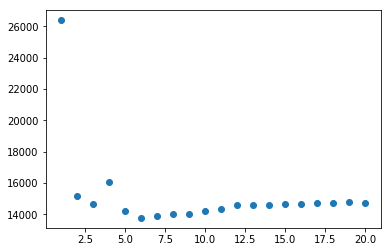

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
features = ['accommodates', 'bedrooms', 'bathrooms', 'number_of_reviews']
hyper_params = [x for x in range(1, 21)]
mse_values = list()

for hp in hyper_params:
    knn = KNeighborsRegressor(n_neighbors=hp, algorithm='brute')
    knn.fit(train_df[features], train_df['price'])
    predictions = knn.predict(test_df[features])
    mse = mean_squared_error(test_df['price'], predictions)
    mse_values.append(mse)
print(mse_values)
plt.scatter(hyper_params, mse_values)

As we increased the k value from 1 to 6, the MSE value decreased from approximately 26364 to approximately 13657. However, as we increased the k value from 7 to 20, the MSE value didn't decrease further but instead hovered between approximately 14015 and 14755. This means that the optimal k value is 6, since it resulted in the lowest MSE value.

From the scatter plot, you can tell that the lowest MSE value was achieved at the k value of 6. As we increased k past 6, the MSE actually increased and hovered but never decreased below 13781 (the approximate MSE value when k was 6)
This pattern is something you'll notice while performing grid search across other models as well. As you increase k at first, the error rate decreases until a certain point, but then rebounds and increases again. Let's confirm this behavior visually using a scatter plot.



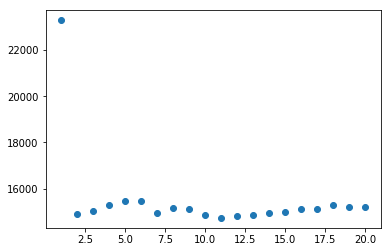

In [22]:
#Now, lets put the k-nearest models to all the columns except for the price column
hyper_params = [x for x in range(1,21)]
mse_values = list()
features = train_df.columns.tolist()
features.remove('price')

for hp in hyper_params:
    knn = KNeighborsRegressor(n_neighbors=hp, algorithm='brute')
    knn.fit(train_df[features], train_df['price'])
    predictions = knn.predict(test_df[features])
    mse = mean_squared_error(test_df['price'], predictions)
    mse_values.append(mse)

plt.scatter(hyper_params, mse_values)
plt.show()

While using only the accommodates and bathrooms columns:

Train a model for each k value between 1 and 20 using the training data.
Use each model to make predictions on the test set (using just the accommodates and bathrooms columns).
Calculate each model's MSE value by comparing each set of predictions to the true price values.
Find the k value that obtained the lowest MSE value.
Create a dictionary named two_hyp_mse that contains 1 key-value pair:
key: k value that resulted in lowest MSE value.
value: corresponding MSE value.
Repeat this process while using only the accommodates, bathrooms, and bedrooms columns:

Create a dictionary named three_hyp_mse that contains 1 key-value pair:
key: k value that resulted in lowest MSE value.
value: corresponding MSE value.
Display both two_hyp_mse and three_hyp_mse using the print() function.

In [23]:
two_features = ['accommodates', 'bathrooms']
three_features = ['accommodates', 'bathrooms', 'bedrooms']
hyper_params = [x for x in range(1,21)]
# Append the first model's MSE values to this list.
two_mse_values = list()
# Append the second model's MSE values to this list.
three_mse_values = list()
two_hyp_mse = dict()
three_hyp_mse = dict()
for hp in hyper_params:
    knn = KNeighborsRegressor(n_neighbors=hp, algorithm='brute')
    knn.fit(train_df[two_features], train_df['price'])
    predictions = knn.predict(test_df[two_features])
    mse = mean_squared_error(test_df['price'], predictions)
    two_mse_values.append(mse)

two_lowest_mse = two_mse_values[0]
two_lowest_k = 1

for k,mse in enumerate(two_mse_values):
    if mse < two_lowest_mse:
        two_lowest_mse = mse
        two_lowest_k = k + 1
    
for hp in hyper_params:
    knn = KNeighborsRegressor(n_neighbors=hp, algorithm='brute')
    knn.fit(train_df[three_features], train_df['price'])
    predictions = knn.predict(test_df[three_features])
    mse = mean_squared_error(test_df['price'], predictions)
    three_mse_values.append(mse)
    
three_lowest_mse = three_mse_values[0]
three_lowest_k = 1

for k,mse in enumerate(three_mse_values):
    if mse < three_lowest_mse:
        three_lowest_mse = mse
        three_lowest_k = k + 1

two_hyp_mse[two_lowest_k] = two_lowest_mse
three_hyp_mse[three_lowest_k] = three_lowest_mse

print(two_hyp_mse)
print(three_hyp_mse)

{5: 14875.319590443689}
{5: 13494.16850967008}


The first model, which used the accommodates and bathrooms columns, was able to achieve an MSE value of approximately 14790. The second model, which added the bedrooms column, was able to achieve an MSE value of approximately 13522.9, which is even lower than the lowest MSE value we achieved using the best model from the last mission (which used the accommodates, bedrooms, bathrooms, and number_of_reviews columns). Hopefully this demonstrates that using just one lever to find the best model isn't enough and you really want to use both levers in conjunction

#Cross validation 
we'll focus on the holdout validation technique, which involves:

splitting the full dataset into 2 partitions:
a training set
a test set
training the model on the training set,
using the trained model to predict labels on the test set,
computing an error metric to understand the model's effectiveness,
switch the training and test sets and repeat,
average the errors.
In holdout validation, we usually use a 50/50 split instead of the 75/25 split from train/test validation. This way, we remove number of observations as a potential source of variation in our model performance.

In [26]:
dc_listings = pd.read_csv("dc_airbnb.csv")
stripped_commas = dc_listings['price'].str.replace(',', '')
stripped_dollars = stripped_commas.str.replace('$', '')
dc_listings['price'] = stripped_dollars.astype('float')
shuffled_index = np.random.permutation(dc_listings.index)
dc_listings = dc_listings.reindex(shuffled_index)

split_one = dc_listings.iloc[0:1862].copy()
split_two = dc_listings.iloc[1862:].copy()

train_one = split_one
test_one = split_two
train_two = split_two
test_two = split_one
# First half
model = KNeighborsRegressor()
model.fit(train_one[["accommodates"]], train_one["price"])
test_one["predicted_price"] = model.predict(test_one[["accommodates"]])
iteration_one_rmse = mean_squared_error(test_one["price"], test_one["predicted_price"])**(1/2)

# Second half
model.fit(train_two[["accommodates"]], train_two["price"])
test_two["predicted_price"] = model.predict(test_two[["accommodates"]])
iteration_two_rmse = mean_squared_error(test_two["price"], test_two["predicted_price"])**(1/2)

avg_rmse = np.mean([iteration_two_rmse, iteration_one_rmse])

print(iteration_one_rmse, iteration_two_rmse, avg_rmse)

118.9972283485966 142.82709375697377 130.91216105278517



If we average the two RMSE values from the last step, we get an RMSE value of approximately 130.91. Holdout validation is actually a specific example of a larger class of validation techniques called k-fold cross-validation. While holdout validation is better than train/test validation because the model isn't repeatedly biased towards a specific subset of the data, both models that are trained only use half the available data. K-fold cross validation, on the other hand, takes advantage of a larger proportion of the data during training while still rotating through different subsets of the data to avoid the issues of train/test validation.

#kcross validation
Here's the algorithm from k-fold cross validation:

-splitting the full dataset into k equal length partitions.
-selecting k-1 partitions as the training set and
-selecting the remaining partition as the test set
-training the model on the training set.
-using the trained model to predict labels on the test fold.
-computing the test fold's error metric.
-repeating all of the above steps k-1 times, until each partition has been used as the test set for an iteration.
calculating the mean of the k error values.
-Holdout validation is essentially a version of k-fold cross validation when k is equal to 2. Generally, 5 or 10 folds is used for k-fold cross-validation

In [27]:

dc_listings.loc[dc_listings.index[0:745], "fold"] = 1
dc_listings.loc[dc_listings.index[745:1490], "fold"] = 2
dc_listings.loc[dc_listings.index[1490:2234], "fold"] = 3
dc_listings.loc[dc_listings.index[2234:2978], "fold"] = 4
dc_listings.loc[dc_listings.index[2978:3723], "fold"] = 5
print(dc_listings['fold'].value_counts())
print("\n Num of missing values: ", dc_listings['fold'].isnull().sum())

5.0    745
2.0    745
1.0    745
4.0    744
3.0    744
Name: fold, dtype: int64

 Num of missing values:  0


-Train a k-nearest neighbors model using the accommodates column as the sole feature from folds 2 to 5 as the training set.
-Use the model to make predictions on the test set (accommodates column from fold 1) and assign the predicted labels to labels.
-Calculate the RMSE value by comparing the price column with the predicted labels.
-Assign the RMSE value to iteration_one_rmse

In [28]:
# Training
model = KNeighborsRegressor()
train_iteration_one = dc_listings[dc_listings["fold"] != 1]
test_iteration_one = dc_listings[dc_listings["fold"] == 1].copy()
model.fit(train_iteration_one[["accommodates"]], train_iteration_one["price"])

# Predicting
labels = model.predict(test_iteration_one[["accommodates"]])
test_iteration_one["predicted_price"] = labels
iteration_one_mse = mean_squared_error(test_iteration_one["price"], test_iteration_one["predicted_price"])
iteration_one_rmse = iteration_one_mse ** (1/2)


Write a function named train_and_validate that takes in a dataframe as the first parameter (df) and a list of fold values (1 to 5 in our case) as the second parameter (folds). This function should:

Train n models (where n is number of folds) and perform k-fold cross validation (using n folds). Use the default k value for the KNeighborsRegressor class.
Return a list of RMSE values, where the first element is the RMSE for when fold 1 was the test set, the second element is the RMSE for when fold 2 was the test set, and so on.
Use the train_and_validate function to return the list of RMSE values for the dc_listings Dataframe and assign to rmses.

Calculate the mean of these values and assign to avg_rmse.
Display both rmses and avg_rmse.

In [29]:
# Use np.mean to calculate the mean.
import numpy as np
fold_ids = [1,2,3,4,5]
def train_and_validate(df, folds):
    fold_rmses = []
    for fold in folds:
        # Train
        model = KNeighborsRegressor()
        train = df[df["fold"] != fold]
        test = df[df["fold"] == fold].copy()
        model.fit(train[["accommodates"]], train["price"])
        # Predict
        labels = model.predict(test[["accommodates"]])
        test["predicted_price"] = labels
        mse = mean_squared_error(test["price"], test["predicted_price"])
        rmse = mse**(1/2)
        fold_rmses.append(rmse)
    return(fold_rmses)

rmses = train_and_validate(dc_listings, fold_ids)
print(rmses)
avg_rmse = np.mean(rmses)
print(avg_rmse)

[134.48877940272527, 121.4580456744649, 147.52190305754746, 96.314530944026, 145.92810402257734]
129.1422726202682


Now, using k-cross validation through scikit learn
In machine learning, we're interested in building a good model and accurately understanding how well it will perform. To build a better k-nearest neighbors model, we can change the features it uses or tweak the number of neighbors (a hyperparameter). To accurately understand a model's performance, we can perform k-fold cross validation and select the proper number of folds. We've learned how scikit-learn makes it easy for us to quickly experiment with these different knobs when it comes to building a better model. Let's now dive into how we can use scikit-learn to handle cross-validation as well.

First, we instantiate an instance of the KFold class from sklearn.model_selection:


from sklearn.model_selection import KFold
kf = KFold(n_splits, shuffle=False, random_state=None)
where:

n_splits is the number of folds you want to use,
shuffle is used to toggle shuffling of the ordering of the observations in the dataset,
random_state is used to specify the random seed value if shuffle is set to True.
You'll notice here that no parameters depend on the data set at all. This is because the KFold class returns an iterator object which we use in conjunction with the cross_val_score() function, also from sklearn.model_selection. Together, these 2 functions allow us to compactly train and test using k-fold cross validation:

Here are the relevant parameters for the cross_val_score function:


from sklearn.model_selection import cross_val_score
cross_val_score(estimator, X, Y, scoring=None, cv=None)
where:

estimator is a sklearn model that implements the fit method (e.g. instance of KNeighborsRegressor),
X is the list or 2D array containing the features you want to train on,
y is a list containing the values you want to predict (target column),
scoring is a string describing the scoring criteria (list of accepted values here).
cv describes the number of folds. Here are some examples of accepted values:
an instance of the KFold class,
an integer representing the number of folds.
Depending on the scoring criteria you specify, a single total value is returned for each fold. Here's the general workflow for performing k-fold cross-validation using the classes we just described:

instantiate the scikit-learn model class you want to fit,
instantiate the KFold class and using the parameters to specify the k-fold cross-validation attributes you want,
use the cross_val_score() function to return the scoring metric you're interested in.

In [30]:
from sklearn.model_selection import cross_val_score, KFold
kf = KFold(5, shuffle=True, random_state=1)
model = KNeighborsRegressor()
mses = cross_val_score(model, dc_listings[["accommodates"]], dc_listings["price"], scoring="neg_mean_squared_error", cv=kf)
rmses = np.sqrt(np.absolute(mses))
avg_rmse = np.mean(rmses)

print(rmses)
print(avg_rmse)

[149.55342652 157.37125924 129.69069699 120.28923029 134.58266836]
138.29745628067826
